In [17]:
import os
print(os.getcwd())

C:\Users\Sharanya


In [19]:
import os

train_dir = r"C:/Users/Sharanya/Documents/Semester3/DeepLearning/DLProject/FruitsAndVegetables/dataset/train"
test_dir  = r"C:/Users/Sharanya/Documents/Semester3/DeepLearning/DLProject/FruitsAndVegetables/dataset/test"

In [21]:
train_dir, test_dir

('C:/Users/Sharanya/Documents/Semester3/DeepLearning/DLProject/FruitsAndVegetables/dataset/train',
 'C:/Users/Sharanya/Documents/Semester3/DeepLearning/DLProject/FruitsAndVegetables/dataset/test')

In [23]:
print("Train exists:", os.path.exists(train_dir))
print("Test exists:", os.path.exists(test_dir))

if os.path.exists(train_dir):
    print("Train classes:", os.listdir(train_dir))

Train exists: True
Test exists: True
Train classes: ['fresh', 'freshapples', 'freshbanana', 'freshbittergroud', 'freshcapsicum', 'freshcucumber', 'freshokra', 'freshoranges', 'freshpotato', 'freshtomato', 'rotten', 'rottenapples', 'rottenbanana', 'rottenbittergroud', 'rottencapsicum', 'rottencucumber', 'rottenokra', 'rottenoranges', 'rottenpotato', 'rottentomato']


In [27]:
#THIS IS A ONE-TIME PROCESS
#DON'T RERUN
import os
import shutil

base_path = r"C:/Users/Sharanya/Documents/Semester3/DeepLearning/DLProject/FruitsAndVegetables/dataset"

for split in ['train', 'test']:
    split_path = os.path.join(base_path, split)

    fresh_dir = os.path.join(split_path, 'fresh')
    rotten_dir = os.path.join(split_path, 'rotten')

    os.makedirs(fresh_dir, exist_ok=True)
    os.makedirs(rotten_dir, exist_ok=True)

    for folder in os.listdir(split_path):
        folder_path = os.path.join(split_path, folder)

        #SKIP the already-created binary folders
        if folder in ['fresh', 'rotten']:
            continue

        if os.path.isdir(folder_path):
            if folder.startswith('fresh'):
                for img in os.listdir(folder_path):
                    src = os.path.join(folder_path, img)
                    dst = os.path.join(fresh_dir, img)

                    if not os.path.exists(dst):  # extra safety
                        shutil.copy(src, dst)

            elif folder.startswith('rotten'):
                for img in os.listdir(folder_path):
                    src = os.path.join(folder_path, img)
                    dst = os.path.join(rotten_dir, img)

                    if not os.path.exists(dst):  # extra safety
                        shutil.copy(src, dst)

In [29]:
print(os.listdir(train_dir))
print("Fresh samples:", len(os.listdir(os.path.join(train_dir, "fresh"))))
print("Rotten samples:", len(os.listdir(os.path.join(train_dir, "rotten"))))

['fresh', 'freshapples', 'freshbanana', 'freshbittergroud', 'freshcapsicum', 'freshcucumber', 'freshokra', 'freshoranges', 'freshpotato', 'freshtomato', 'rotten', 'rottenapples', 'rottenbanana', 'rottenbittergroud', 'rottencapsicum', 'rottencucumber', 'rottenokra', 'rottenoranges', 'rottenpotato', 'rottentomato']
Fresh samples: 11200
Rotten samples: 12419


In [49]:
#Import all needed libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

import cv2
import numpy as np
import matplotlib.pyplot as plt

In [51]:
#Dataset paths - already verified above
train_dir = r"C:/Users/Sharanya/Documents/Semester3/DeepLearning/DLProject/FruitsAndVegetables/dataset/train"
test_dir  = r"C:/Users/Sharanya/Documents/Semester3/DeepLearning/DLProject/FruitsAndVegetables/dataset/test"

In [53]:
#Parameters for images
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32
EPOCHS = 10

In [55]:
def preprocess_image(img):
    # Ensure uint8 type (CRITICAL FIX)
    if img.dtype != np.uint8:
        img = img.astype(np.uint8)

    # Resize
    img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))

    # Convert RGB → LAB
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)

    # CLAHE works ONLY on uint8/uint16
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    l = clahe.apply(l)

    # Merge and convert back to RGB
    lab = cv2.merge((l, a, b))
    img = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)

    # Gaussian blur
    img = cv2.GaussianBlur(img, (3, 3), 0)

    # Normalize AFTER OpenCV ops
    img = img.astype(np.float32) / 255.0

    return img

In [39]:
#Data generators - binary classification
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_image
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_image
)

train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

Found 47238 images belonging to 20 classes.
Found 13476 images belonging to 16 classes.


In [59]:
#CNN architecture
model = Sequential()

# Block 1
model.add(Conv2D(32, (3,3), activation='relu',
                 input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)))
model.add(MaxPooling2D(2,2))

# Block 2
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(2,2))

# Block 3
model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D(2,2))

# Classifier
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

In [61]:
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [63]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │      11,075,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,169,089 (42.61 MB)

 Trainable params: 11,169,089 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [65]:
history = model.fit(
    train_data,
    epochs=EPOCHS,
    validation_data=test_data
)

error: OpenCV(4.12.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\clahe.cpp:353: error: (-215:Assertion failed) _src.type() == CV_8UC1 || _src.type() == CV_16UC1 in function '`anonymous-namespace'::CLAHE_Impl::apply'


In [ ]:
#Plot accuracy and loss

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title("Accuracy")

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Loss")

plt.show()

In [ ]:
#Save the model
model.save("fresh_vs_rotten_cnn_opencv.h5")

In [ ]:
#Test on a single image
from tensorflow.keras.preprocessing import image

img_path = "test_image.jpg"  # any image path
img = image.load_img(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
img = image.img_to_array(img)
img = preprocess_image(img)
img = np.expand_dims(img, axis=0)

prediction = model.predict(img)

print("Prediction value:", prediction[0][0])

if prediction[0][0] > 0.5:
    print("Prediction: Rotten")
else:
    print("Prediction: Fresh")


#SREYAS CODE

In [67]:
#Without augmentation and 15 epochs
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import numpy as np

# Configuration
DATASET_PATH = (r"C:\Users\Sharanya\Documents\Semester3\DeepLearning\DLProject\FruitsAndVegetables\dataset")
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 15

# Data generators - simple normalization only
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Load data
train_generator = train_datagen.flow_from_directory(
    f'{DATASET_PATH}/train',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    f'{DATASET_PATH}/train',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    f'{DATASET_PATH}/test',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

NUM_CLASSES = len(train_generator.class_indices)
CLASS_NAMES = list(train_generator.class_indices.keys())

print(f"Classes: {NUM_CLASSES}")
print(f"Train: {train_generator.samples}")
print(f"Val: {val_generator.samples}")
print(f"Test: {test_generator.samples}")

# Simple CNN model
model = Sequential([
    Conv2D(32, 3, activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    MaxPooling2D(2),
    
    Conv2D(64, 3, activation='relu'),
    MaxPooling2D(2),
    
    Conv2D(128, 3, activation='relu'),
    MaxPooling2D(2),
    
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(NUM_CLASSES, activation='softmax')
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

# Train model
callbacks = [EarlyStopping(patience=5, restore_best_weights=True)]
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=val_generator,
    callbacks=callbacks
)

# Plot results
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val')
plt.title('Loss')
plt.legend()
plt.show()

# Test evaluation
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Save model
model.save('vegetable_model.h5')

# Prediction function
def predict_image(image_path):
    model = tf.keras.models.load_model('vegetable_model.h5')
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(IMG_SIZE, IMG_SIZE))
    img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, 0)
    pred = model.predict(img_array)[0]
    class_name = CLASS_NAMES[np.argmax(pred)]
    confidence = np.max(pred) * 100
    plt.imshow(img)
    plt.title(f'{class_name}: {confidence:.1f}%')
    plt.axis('off')
    plt.show()
    return class_name, confidence

print("Done")

Found 37797 images belonging to 20 classes.
Found 9441 images belonging to 20 classes.
Found 13476 images belonging to 16 classes.
Classes: 20
Train: 37797
Val: 9441
Test: 13476


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)                    │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 512)                 │      44,302,848 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 20)                  │          10,260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 44,406,356 (169.40 MB)

 Trainable params: 44,406,356 (169.40 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
  19/1181 ━━━━━━━━━━━━━━━━━━━━ 1:25:28 4s/step - accuracy: 0.1579 - loss: 4.7288

KeyboardInterrupt: 

TRYING THE PLANT DISEASE DETECTION DATASET

In [1]:
import os #helps interact with folders and files (used to read image directories).
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
#Giving the path for our dataset
DATASET_DIR = r"C:/Users/Sharanya/Documents/Semester3/DeepLearning/DLProject/Plant disease detection/Dataset"

In [5]:
#counting images per class
class_counts = {}

for class_name in os.listdir(DATASET_DIR):
    class_path = os.path.join(DATASET_DIR, class_name)

    if os.path.isdir(class_path):
        num_images = len([
            img for img in os.listdir(class_path)
            if img.lower().endswith(('.png', '.jpg', '.jpeg'))
        ])
        class_counts[class_name] = num_images

# Convert to DataFrame
df_class_counts = pd.DataFrame.from_dict(
    class_counts, orient='index', columns=['Image_Count']
).sort_values(by='Image_Count', ascending=False)

df_class_counts

,Image_Count
Tomato__Tomato_YellowLeaf__Curl_Virus,3208
Tomato_Bacterial_spot,2127
Apple___Apple_scab,2016
Apple___healthy,2008
Apple___Black_rot,1987
Tomato_Late_blight,1909
Corn_(maize)___Northern_Leaf_Blight,1908
Corn_(maize)___Common_rust_,1907
Corn_(maize)___healthy,1859
Tomato_Septoria_leaf_spot,1771


In [7]:
#Counting the no. of images per crop
# Function to normalize crop names
def normalize_crop_name(class_name):
    crop = class_name.split('___')[0].lower()

    if crop.startswith('tomato'):
        return 'Tomato'
    elif crop.startswith('apple'):
        return 'Apple'
    elif crop.startswith('potato'):
        return 'Potato'
    elif crop.startswith('corn'):
        return 'Corn'
    elif crop.startswith('pepper'):
        return 'Pepper'
    else:
        return crop.capitalize()

# List to store results
data = []

# Iterate through class folders
for class_name in os.listdir(DATASET_DIR):
    class_path = os.path.join(DATASET_DIR, class_name)

    if os.path.isdir(class_path):
        image_count = len([
            img for img in os.listdir(class_path)
            if img.lower().endswith(('.png', '.jpg', '.jpeg'))
        ])

        crop_name = normalize_crop_name(class_name)

        data.append({
            "Crop": crop_name,
            "Class": class_name,
            "Image_Count": image_count
        })

In [9]:
# Create DataFrame
df = pd.DataFrame(data)

# Sort so crops are grouped together
df_sorted = df.sort_values(
    by=["Crop", "Image_Count"],
    ascending=[True, False]
)

df_sorted

,Crop,Class,Image_Count
0,Apple,Apple___Apple_scab,2016
3,Apple,Apple___healthy,2008
1,Apple,Apple___Black_rot,1987
2,Apple,Apple___Cedar_apple_rust,1760
7,Corn,Corn_(maize)___Northern_Leaf_Blight,1908
5,Corn,Corn_(maize)___Common_rust_,1907
6,Corn,Corn_(maize)___healthy,1859
4,Corn,Corn_(maize)___Cercospora_leaf_spot Gray_leaf_...,1642
9,Pepper,Pepper__bell___healthy,1478
8,Pepper,Pepper__bell___Bacterial_spot,997


In [11]:
#Total images per crop
df_crop_totals = (
    df_sorted.groupby("Crop")["Image_Count"]
    .sum()
    .sort_values(ascending=False)
    .reset_index()
)

df_crop_totals

,Crop,Image_Count
0,Tomato,16011
1,Apple,7771
2,Corn,7316
3,Pepper,2475
4,Potato,2152


In [ ]:
#We can say that the dataset isn't severely imbalanced or very mildly imbalanced as we have almost equal no of images for each type of disease and healthy crops
#The model sees all diseases and healthy crops equally

In [13]:
#Training Testing split
#70 training, 15 validation, 15 testing
#We split at the image level, but within each class folder. 
#Every disease class contributes images to all three splits
#Class distribution is preserved across splits (stratified split)

In [23]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [24]:
IMG_HEIGHT = 224
IMG_WIDTH = 224

def preprocess_image(img):
    """
    OpenCV-based preprocessing for plant disease detection:
    - Resize
    - Contrast enhancement using CLAHE
    - Noise reduction
    - Normalization
    """

    # Ensure image is uint8 for OpenCV operations
    if img.dtype != np.uint8:
        img = img.astype(np.uint8)

    # Resize
    img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))

    # Convert RGB to LAB color space
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)

    # Apply CLAHE on L channel #Use for contrast - Contrast Limited Adaptive Histogram Equalization
    #Makes subtle patterns (like disease spots or textures) more visible
    #Works well when lighting is uneven
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    l = clahe.apply(l)

    # Merge channels and convert back to RGB
    lab = cv2.merge((l, a, b))
    img = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)

    # Gaussian blur for noise reduction
    img = cv2.GaussianBlur(img, (3, 3), 0)

    # Normalize pixel values
    img = img.astype(np.float32) / 255.0

    return img

In [25]:
ImageDataGenerator(
    preprocessing_function=preprocess_image
)
#Reads images directly from folders
#Resizes and normalizes them
#Applies data augmentation (rotate, flip, zoom, etc.)
#Generates image batches for training and validation

In [29]:
print(ImageDataGenerator)

<class 'keras.src.legacy.preprocessing.image.ImageDataGenerator'>


In [31]:
#Data Generators
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [33]:
DATASET_DIR = r"C:/Users/Sharanya/Documents/Semester3/DeepLearning/DLProject/Plant disease detection/Dataset"

In [35]:
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32
VALIDATION_SPLIT = 0.15

In [37]:
datagen = ImageDataGenerator(
    preprocessing_function=preprocess_image,
    validation_split=VALIDATION_SPLIT
)

In [41]:
#Training Generator
train_generator = datagen.flow_from_directory(
    DATASET_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

Found 30375 images belonging to 23 classes.


In [43]:
#Validation Generator
val_generator = datagen.flow_from_directory(
    DATASET_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

Found 5350 images belonging to 23 classes.


In [45]:
print("Number of classes:", train_generator.num_classes)
print("Class indices:")
print(train_generator.class_indices)

print("Training samples:", train_generator.samples)
print("Validation samples:", val_generator.samples)

Number of classes: 23
Class indices:
{'Apple___Apple_scab': 0, 'Apple___Black_rot': 1, 'Apple___Cedar_apple_rust': 2, 'Apple___healthy': 3, 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot': 4, 'Corn_(maize)___Common_rust_': 5, 'Corn_(maize)___Northern_Leaf_Blight': 6, 'Corn_(maize)___healthy': 7, 'Pepper__bell___Bacterial_spot': 8, 'Pepper__bell___healthy': 9, 'Potato___Early_blight': 10, 'Potato___Late_blight': 11, 'Potato___healthy': 12, 'Tomato_Bacterial_spot': 13, 'Tomato_Early_blight': 14, 'Tomato_Late_blight': 15, 'Tomato_Leaf_Mold': 16, 'Tomato_Septoria_leaf_spot': 17, 'Tomato_Spider_mites_Two_spotted_spider_mite': 18, 'Tomato__Target_Spot': 19, 'Tomato__Tomato_YellowLeaf__Curl_Virus': 20, 'Tomato__Tomato_mosaic_virus': 21, 'Tomato_healthy': 22}
Training samples: 30375
Validation samples: 5350


In [47]:
#CNN ARCHITECTURE
#Library imports

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Dense, Flatten,
    Dropout, BatchNormalization
)
from tensorflow.keras.optimizers import Adam


In [94]:
#Why ReLU
'''Keeps positive values as they are
Converts negative values to zero
Why ReLU is used:
Introduces non-linearity (helps the model learn complex patterns)
Faster to compute
Reduces vanishing gradient problem'''

'''
Conv2D → extracts features like edges, textures
MaxPooling → reduces size, keeps important info
Deeper layers → learn complex patterns (disease spots)
Flatten → prepares data for classification
Dense + ReLU → decision making
Dropout (0.5) → prevents overfitting
Softmax output → predicts disease class'''

'''Block 1	32	Edges, corners, color gradients
Block 2	64	Simple shapes, leaf veins, outlines
Block 3	128	Disease spots, textures, patterns
Block 4	256	Complex disease regions & combinations'''

''' Why pooling layer after each convolution layer: 
Reduces image size
Keeps important features
Makes model faster and more robust'''

'''Why BatchNormalization: it stabilizes the learning and improves the accuracy'''

' Why pooling layer after each convolution layer: \nReduces image size\nKeeps important features\nMakes model faster and more robust'

In [49]:
#Define cnn model
NUM_CLASSES = train_generator.num_classes

model = Sequential()

# -------- Block 1 --------
model.add(Conv2D(32, (3,3), padding='same',
                 activation='relu',
                 input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))

# -------- Block 2 --------
model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))

# -------- Block 3 --------
model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))

# -------- Block 4 --------
model.add(Conv2D(256, (3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))

# -------- Classifier --------
model.add(Flatten())

model.add(Dense(512, activation='relu')) #Does the main classification #combines all the learned features, and learns all the relationships
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(256, activation='relu')) #learns better, reduces dimensionality, helps avoid overfitting, refines the classification decision
model.add(Dropout(0.3))
#A single dense layer might be too quick to shift from images to classes, 2 dense layers helps with a more stable classification

# Output layer
model.add(Dense(NUM_CLASSES, activation='softmax'))

C:\Users\Sharanya\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [53]:
#Compile the model
model.compile(
    optimizer=Adam(learning_rate=1e-4), #it trains faster and adapts the learning rate automatically
    #1e-4: slow learner, stable and controlled learning for a deep CNN, especially when training on image data.
    loss='categorical_crossentropy', #as it is a multiclass classification problem
    metrics=['accuracy']
)

In [55]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 224, 224, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 56, 56, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 28, 28, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 28, 28, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 14, 14, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 50176)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      25,690,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 23)                  │           5,9

 Total params: 26,220,247 (100.02 MB)

 Trainable params: 26,218,263 (100.01 MB)

 Non-trainable params: 1,984 (7.75 KB)

In [57]:
#training the model
EPOCHS = 30

In [59]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
#EarlyStopping: Stops training automatically when the model stops improving on validation data.
'''monitor='val_loss' → watches validation loss
patience=5 → waits 5 epochs after the last improvement
restore_best_weights=True → restores the weights from the best epoch'''
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

checkpoint = ModelCheckpoint( #Saves the best version of the model during training.
    filepath='plant_disease_cnn_best.h5',
    monitor='val_loss',
    save_best_only=True
)

In [61]:
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    callbacks=[early_stop, checkpoint]
)

C:\Users\Sharanya\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
950/950 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6191 - loss: 1.3226

950/950 ━━━━━━━━━━━━━━━━━━━━ 2515s 3s/step - accuracy: 0.7453 - loss: 0.8503 - val_accuracy: 0.8940 - val_loss: 0.3414
Epoch 2/30
950/950 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.8882 - loss: 0.3578

950/950 ━━━━━━━━━━━━━━━━━━━━ 7354s 8s/step - accuracy: 0.8968 - loss: 0.3274 - val_accuracy: 0.9226 - val_loss: 0.2413
Epoch 3/30
950/950 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9410 - loss: 0.1953

950/950 ━━━━━━━━━━━━━━━━━━━━ 2950s 3s/step - accuracy: 0.9419 - loss: 0.1917 - val_accuracy: 0.9439 - val_loss: 0.1768
Epoch 4/30
950/950 ━━━━━━━━━━━━━━━━━━━━ 3215s 3s/step - accuracy: 0.9597 - loss: 0.1212 - val_accuracy: 0.9082 - val_loss: 0.2758
Epoch 5/30
950/950 ━━━━━━━━━━━━━━━━━━━━ 18459s 19s/step - accuracy: 0.9750 - loss: 0.0795 - val_accuracy: 0.9346 - val_loss: 0.2059
Epoch 6/30
 70/950 ━━━━━━━━━━━━━━━━━━━━ 6:46:02 28s/step - accuracy: 0.9866 - loss: 0.0563

KeyboardInterrupt: 

In [66]:
#Loading the best trained model
from tensorflow.keras.models import load_model
model = load_model("plant_disease_cnn_best.h5")

In [68]:
#Evaluate the model
val_loss, val_accuracy = model.evaluate(val_generator)
print("Validation Accuracy:", val_accuracy)
print("Validation Loss:", val_loss)

168/168 ━━━━━━━━━━━━━━━━━━━━ 312s 2s/step - accuracy: 0.9439 - loss: 0.1768
Validation Accuracy: 0.9439252614974976
Validation Loss: 0.17680393159389496


In [74]:
import numpy as np

# True labels
y_true = val_generator.classes

# Predicted labels
y_pred_prob = model.predict(val_generator)
y_pred = np.argmax(y_pred_prob, axis=1)

168/168 ━━━━━━━━━━━━━━━━━━━━ 299s 2s/step


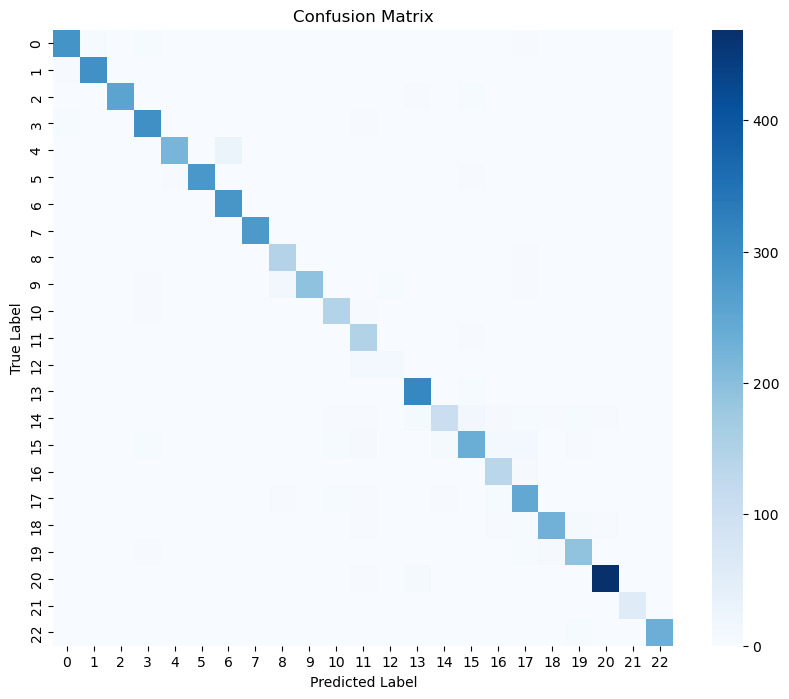

In [76]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10,8))
sns.heatmap(cm, cmap="Blues", cbar=True)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [78]:
from sklearn.metrics import classification_report

class_labels = list(val_generator.class_indices.keys())

print(classification_report(
    y_true,
    y_pred,
    target_names=class_labels
))

                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.97      0.95      0.96       302
                                 Apple___Black_rot       0.99      0.99      0.99       298
                          Apple___Cedar_apple_rust       1.00      0.97      0.98       264
                                   Apple___healthy       0.94      0.98      0.96       301
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.99      0.89      0.94       246
                       Corn_(maize)___Common_rust_       1.00      0.99      0.99       286
               Corn_(maize)___Northern_Leaf_Blight       0.92      1.00      0.95       286
                            Corn_(maize)___healthy       1.00      1.00      1.00       278
                     Pepper__bell___Bacterial_spot       0.88      0.97      0.92       149
                            Pepper__bell___healthy       0.99      0.87      0.

In [80]:
class_labels = list(val_generator.class_indices.keys())
#extracts the class names (labels) from the validation data generator and stores them as a list

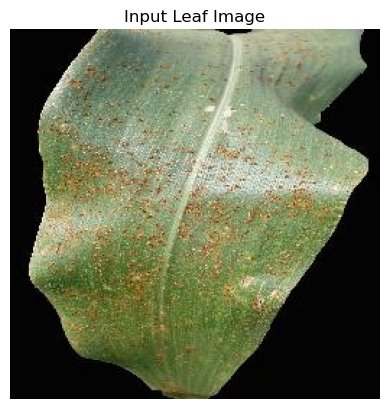

In [86]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

img_path = r"C:/Users/Sharanya/Documents/Semester3/DeepLearning/DLProject/Plant disease detection/Dataset/Corn_(maize)___Common_rust_/RS_Rust 1566.jpg"  # <-- change this

# Load image using OpenCV
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Show original image
plt.imshow(img)
plt.axis('off')
plt.title("Input Leaf Image")
plt.show()

# Preprocess (reuse SAME function used in training)
img_processed = preprocess_image(img)

# Add batch dimension
img_processed = np.expand_dims(img_processed, axis=0)

In [88]:
predictions = model.predict(img_processed)

predicted_class_index = np.argmax(predictions)
predicted_class = class_labels[predicted_class_index]
confidence = predictions[0][predicted_class_index] * 100

print(f"Predicted Class: {predicted_class}")
print(f"Confidence: {confidence:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step
Predicted Class: Corn_(maize)___Common_rust_
Confidence: 100.00%


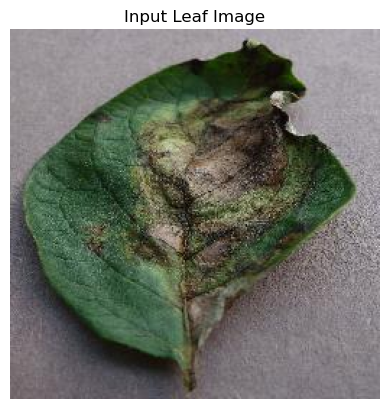

In [96]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

img_path = r"C:/Users/Sharanya/Documents/Semester3/DeepLearning/DLProject/Plant disease detection/Dataset/Potato___Late_blight/0c2628d4-8d64-48a9-a157-19a9c902e304___RS_LB 4590.jpg"  # <-- change this

# Load image using OpenCV
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Show original image
plt.imshow(img)
plt.axis('off')
plt.title("Input Leaf Image")
plt.show()

# Preprocess (reuse SAME function used in training)
img_processed = preprocess_image(img)

# Add batch dimension
img_processed = np.expand_dims(img_processed, axis=0)

In [98]:
predictions = model.predict(img_processed)

predicted_class_index = np.argmax(predictions)
predicted_class = class_labels[predicted_class_index]
confidence = predictions[0][predicted_class_index] * 100

print(f"Predicted Class: {predicted_class}")
print(f"Confidence: {confidence:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step
Predicted Class: Potato___Late_blight
Confidence: 85.19%
